In [1]:
from __future__ import print_function, division
import time, os
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import pandas
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# load cleaned data
#selected_snapshots.read_csv('/home/cs231n/data/snapshots_cleaned.csv')
#selected_repairs.read_csv('/home/cs231n/data/repairs_cleaned.csv')
selected_snapshots = pandas.read_pickle('cleaned_selected_snapshots.pkl')
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')

In [3]:
def split_test_train(repairs):
    mask = (repairs['Chassis\nReference\nNumber']==0) #all false
    
    for repairCode in repairs['ATA9'].unique():    
        v_repairs = repairs[repairs['ATA9'] == repairCode]
        idx = v_repairs.index
        print(repairCode, len(v_repairs))

        if len(v_repairs) > 1:
            # randomly select N cases with matching ATA9 code
            # where N = maxTestCase ~ 20% of #cases with the same ATA9 code
            maxTestCase = math.ceil(0.2*len(v_repairs))
            a = list(range(0,maxTestCase))
            np.random.shuffle(a)
            mask.loc[idx[a[0:maxTestCase]]] = True

    mask.loc[idx[a[0:maxTestCase]]]
    test = repairs[mask][['Chassis\nReference\nNumber','ATA9','Rpr_Dt','Repair Cost']].sort_values('ATA9')
    train = repairs[~mask][['Chassis\nReference\nNumber','ATA9','Rpr_Dt', 'Repair Cost']].sort_values('ATA9')
    
    #print([test, train])
    return [test, train]

In [4]:
very_high_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['very high'])]
[veryhigh_test, veryhigh_train] = split_test_train(very_high_repairs)
[veryhigh_test, veryhigh_train]

45002000 4
45007001 2
45002072 3
43006007 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 140                        27.0  45002000 2016-04-08   very high
 384                       555.0  45002072 2016-05-17   very high
 176                        25.0  45007001 2016-04-22   very high,
      Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 726                       340.0  43006007 2016-06-30   very high
 361                       724.0  45002000 2016-06-10   very high
 507                       495.0  45002000 2016-06-14   very high
 658                       751.0  45002000 2016-06-10   very high
 521                       180.0  45002072 2016-05-31   very high
 696                       801.0  45002072 2016-07-05   very high
 718                       373.0  45007001 2016-07-04   very high]

In [5]:
high_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['high '])]
[high_test, high_train] = split_test_train(high_repairs)
[high_test, high_train]

45007001 3
45002072 2
44003016 1
43004000 2
45008098 2
44004001 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 285                       251.0  43004000 2016-05-18       high 
 171                       470.0  45002072 2016-04-22       high 
 163                       767.0  45007001 2016-04-24       high 
 320                       504.0  45008098 2016-06-10       high ,
      Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 487                       102.0  43004000 2016-06-30       high 
 206                       231.0  44003016 2016-04-15       high 
 500                       180.0  44004001 2016-07-07       high 
 635                       750.0  45002072 2016-06-03       high 
 389                       768.0  45007001 2016-05-11       high 
 554                       674.0  45007001 2016-07-21       high 
 849                       222.0  45008098 2016-06-30       high ]

In [6]:
medium_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['medium'])]
[medium_test, medium_train] = split_test_train(medium_repairs)
[medium_test, medium_train]

44003217 1
43001071 1
45021003 12
44004001 41
45007031 1
45018000 2
43001058 2
45007001 1
44003027 2
45013001 1
43001049 2
45002072 1
13009001 1
101001001 1
43007023 1
44014014 2
3001082 1
43006007 1
45007007 1
45002000 1
43007096 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 362                       571.0  43001049 2016-06-01      medium
 271                       165.0  43001058 2016-04-04      medium
 318                       597.0  44003027 2016-05-31      medium
 92                        182.0  44004001 2016-04-26      medium
 106                       543.0  44004001 2016-03-29      medium
 110                       319.0  44004001 2016-04-13      medium
 147                       460.0  44004001 2016-03-04      medium
 148                        18.0  44004001 2016-04-25      medium
 172                       270.0  44004001 2016-04-14      medium
 202                       233.0  44004001 2016-03-22      medium
 205                       558.0  44004001 2016-03-23      medium
 207                       605.0  44004001 2016-04-19      medium
 654                       722.0  44014014 2016-06-28      medium
 185                       245.0  45018000 2016-04-12      medium
 83       

In [7]:
test = veryhigh_test
train = veryhigh_train
test = test.append(high_test)
test = test.append(medium_test)
train = train.append(high_train)
train = train.append(medium_train)
[len(test), len(train)]

[24, 74]

In [8]:
#-------------------------------------------------------------
# Define: ok = no repairs with medium, high or very high cost
# Split "ok" vehicles into ok_test, ok_train for inclusion in test and train (if necessary)
#-------------------------------------------------------------
# Get "ok" vehicle IDs
ok_veh_ids = list(set(selected_snapshots['Veh Ref ID'].unique()) - set(high_repairs['Chassis\nReference\nNumber'].unique()))
ok_veh_ids = (np.array(ok_veh_ids))

# Get random permutation of indices of ok_veh_ids
a = pandas.Series(np.random.random(len(ok_veh_ids)))
a = a.sort_values().index

# split ok vehicles into test and train with the same proportion as those with medium, high & very high repair Cost 
test_train_proportion = len(test)/(len(test)+len(train))
maxTestCase = round(len(ok_veh_ids)*test_train_proportion)
ok_test = ok_veh_ids[a[0:maxTestCase].values]
ok_train = ok_veh_ids[a[maxTestCase:]]

[len(ok_test),len(ok_train)]

[192, 594]

In [9]:
def get_012_dates(end_date):
    ## split into 0 (10+), 1 (5-10), 2(0-5)
    two_end = end_date
    one_end = pandas.to_datetime(two_end) + pandas.DateOffset(days=-5)
    zero_end = one_end + pandas.DateOffset(days=-5)
    return (zero_end, one_end, two_end)

In [10]:
#-------------------------------------------------------------
# Label Snapshots: creates a new column 'state' in selected_snapshots and populates the state
# 0: 10 or more days before repair date
# 1: 5 - 9 days
# 2: < 5 days before repair date
#-------------------------------------------------------------
# Create a new column 'state' for the label of each snapshot
selected_snapshots['state'] = 0

# List to count #snapshots before each repair date
snapshot_size = []

repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['very high', 'high ', 'medium'])]

# Label state of each snapshot as 0, 1 or 2
for veh_id in repairs['Chassis\nReference\nNumber']:
    v_snapshots = selected_snapshots[selected_snapshots['Veh Ref ID'] == veh_id].sort_values(by='Event DateTime')
    v_repairs = repairs[repairs['Chassis\nReference\nNumber'] == veh_id].sort_values(by='Rpr_Dt')
    
    start = pandas.to_datetime('1/1/2000') ## in past so first snapshot is captured
    event_dt_key = 'Event DateTime'
    state_key = 'state'
    
    for repairDate in v_repairs['Rpr_Dt']: # v_repairs has been sorted by 'Rpr_Dt'       
        mask = (v_snapshots[event_dt_key] > start) & (v_snapshots[event_dt_key] <= repairDate)
        snapshot_size.append({'Chassis\nReference\nNumber':veh_id, 'Rpr_Dt':repairDate, 'Snapshot Qty before Rpr_Dt':sum(mask)})
        
        # divide up snapshots into 0, 1, 2 slices and initialize corresponding state for each snapshot as 0, 1, 2 respectively
        (zero_end, one_end, two_end) = get_012_dates(repairDate)
        two_index = v_snapshots.index[(v_snapshots[event_dt_key] > one_end) & (v_snapshots[event_dt_key] <= two_end)]
        one_index = v_snapshots.index[(v_snapshots[event_dt_key] > zero_end) & (v_snapshots[event_dt_key] <= one_end)]
        zero_index = v_snapshots.index[(v_snapshots[event_dt_key] >= start) & (v_snapshots[event_dt_key] <= zero_end)]
        selected_snapshots.loc[two_index,state_key] = 2
        selected_snapshots.loc[one_index,state_key] = 1
        selected_snapshots.loc[zero_index,state_key] = 0
        
        ## reset start to repairDate to initialize states until next repairDate
        start = repairDate
    
    # initialize states beyond last repair date to 'np.nan'
    other_index = v_snapshots.index[v_snapshots[event_dt_key] > repairDate]
    selected_snapshots.loc[other_index,state_key] = np.nan

# Tabulate #snapshots before repair date for the selected repairs (i.e. medium/high/very high cost)
pandas.DataFrame(snapshot_size)

,Chassis Reference Number,Rpr_Dt,Snapshot Qty before Rpr_Dt
0,208.0,2016-02-18,80
1,761.0,2016-03-08,109
2,765.0,2016-03-07,209
3,60.0,2016-03-31,969
4,182.0,2016-04-26,288
5,543.0,2016-03-29,218
6,319.0,2016-04-13,4
7,27.0,2016-04-08,8
8,460.0,2016-03-04,35
9,18.0,2016-04-25,238


In [11]:
# Count #instance for each state
frequency = []
for s in [0,1,2]:
    frequency.append({s:sum(selected_snapshots['state'] == s)})
frequency.append({'NaN':selected_snapshots['state'].isnull().sum()})

frequency

[{0: 917601}, {1: 4683}, {2: 4698}, {'NaN': 88089}]

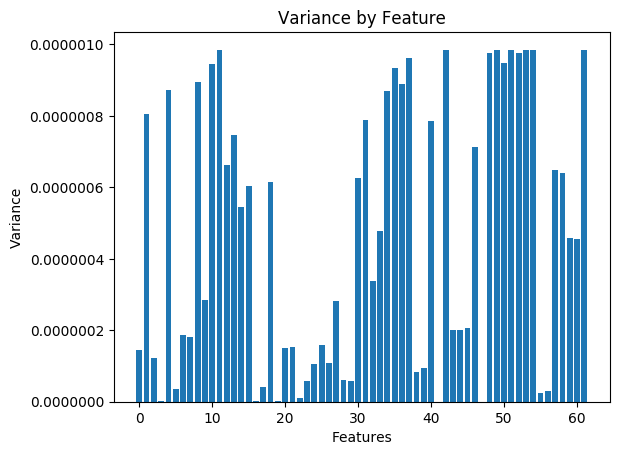

In [12]:
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

# reset index starting from 0 to num_rows
selected_snapshots = selected_snapshots.reset_index(drop=True)

# see http://pbpython.com/categorical-encoding.html
# fill in the NaN values with number 4 
selected_snapshots = selected_snapshots.fillna({"state": 4})
# convert to category
selected_snapshots["Event Type Description"] = selected_snapshots["Event Type Description"].astype('category')

# categories to category codes (ints)
selected_snapshots["Event Type Description"] = selected_snapshots["Event Type Description"].cat.codes

data = selected_snapshots.as_matrix()
#data[~np.isnan(data).any(axis=1)]
y = data[:,-1]
X = data[:,2:-1]

X = X.astype('float64')
X_normalized = prep.normalize(X, norm='l2',axis=0)
y = y.astype('float64')


# low variance feature selection
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
sel.fit_transform(X_normalized) # new X without low variance features
sel.get_support(indices = True) # features that pass the test


fig = plt.bar(np.arange(len(sel.variances_)),sel.variances_, align='center', alpha=1)
#plt.xticks(feature number, variance)
plt.ylabel('Variance')
plt.xlabel('Features')
plt.title('Variance by Feature')
plt.show() 
plt.savefig('plot.png')

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso


X_normalized = prep.normalize(X, norm='l1',axis=0)
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(max_iter=2000)
clf2 = Lasso(alpha = 1, max_iter=2000)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.005)
sfm.fit(X_normalized, y)
X_transform = sfm.transform(X_normalized)
idxs = sfm.get_support(indices = True)
idxs = idxs + 2
for idx in idxs:
    print(list(selected_snapshots)[idx])


Dpf Regen Inhibit Sw
Event - Mil Lamp Time Hr
Event - Red Lamp Time Hr
Part Trap Diff Press
Trip Distance
Altitude
Engine Start Ambient
Engine Start Coolant
Lifetime Idle Fuel
Lifetime Engine Hours
